In [2]:
import os
import shutil

# List of specific ImageNet class IDs to include in the subset
subset_class_ids = [
    "n01440764", "n01491361", "n01498041", "n01514859", "n01530575", "n01616318", "n01622779", "n01629819", "n01641577", "n01664065",
    "n01729322", "n01734418", "n01742172", "n01774750", "n01795545", "n01806143", "n01833805", "n01882714", "n01914609", "n01945685",
    "n01978455", "n01985128", "n02002556", "n02006656", "n02011460", "n02058221", "n02071294", "n02085782", "n02088466", "n02099601",
    "n02100583", "n02104029", "n02106550", "n02110063", "n02110958", "n02112137", "n02113023", "n02113799", "n02123045", "n02128757",
    "n02132136", "n02165456", "n02190166", "n02206856", "n02226429", "n02233338", "n02256656", "n02279972", "n02317335", "n02346627"
]

# Directories 
imagenet_train_dir = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train"
subset_dir = "/kaggle/working/imagenet_subset/train"

# Create target root directory
os.makedirs(subset_dir, exist_ok=True)

# Iterate through specified class IDs
for class_id in subset_class_ids:
    src_class_dir = os.path.join(imagenet_train_dir, class_id)
    dst_class_dir = os.path.join(subset_dir, class_id)
    os.makedirs(dst_class_dir, exist_ok=True)
    
    # List all images
    images = sorted(os.listdir(src_class_dir))
    
    # Copy all images
    for img_name in images:
        src_img_path = os.path.join(src_class_dir, img_name)
        dst_img_path = os.path.join(dst_class_dir, img_name)
        shutil.copyfile(src_img_path, dst_img_path)


In [ ]:
# -----------------------------------------
# train_color_gan.py
# -----------------------------------------
import os, random, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
from skimage import color

# --------- 1. Config ------------------------------------------------
subset_dir   = "/kaggle/working/imagenet_subset/train"   # already built
image_size   = 256
batch_size   = 16
epochs       = 5
λ_L1         = 100
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- 2. Dataset ----------------------------------------------
class LabColorDataset(datasets.ImageFolder):
    """Returns (L, ab) tensors in [-1,1]."""
    def __init__(self, root, size=256):
        super().__init__(root,
            transform=T.Compose([
                T.Resize((size, size)),
                T.RandomHorizontalFlip(),
            ]))
        self.size = size

    def __getitem__(self, idx):
        img_rgb, _ = super().__getitem__(idx)        # PIL
        img_np = np.array(img_rgb) / 255.0
        lab    = color.rgb2lab(img_np).astype("float32")
        L      = lab[..., 0:1] / 50.0 - 1.0          # [-1,1]
        ab     = lab[..., 1:]  / 110.0               # [-1,1]
        L  = torch.from_numpy(L).permute(2,0,1)
        ab = torch.from_numpy(ab).permute(2,0,1)
        return L, ab

ds = LabColorDataset(subset_dir, size=image_size)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True,
                num_workers=4, pin_memory=True)
print(f"[INFO] Loaded {len(ds)} images from {len(ds.classes)} classes")

# --------- 3. Models ------------------------------------------------
def conv(in_c, out_c, k=4, s=2, p=1, bn=True, act=nn.LeakyReLU(0.2)):
    layers=[nn.Conv2d(in_c, out_c, k, s, p, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(out_c))
    layers.append(act)
    return nn.Sequential(*layers)

class UNetG(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.e1 = conv(1,64,bn=False)
        self.e2 = conv(64,128)
        self.e3 = conv(128,256)
        self.e4 = conv(256,512)
        self.e5 = conv(512,512)
        self.e6 = conv(512,512)
        self.e7 = conv(512,512)
        # Decoder
        self.d1 = nn.ConvTranspose2d(512,512,4,2,1,bias=False)
        self.d2 = nn.ConvTranspose2d(1024,512,4,2,1,bias=False)
        self.d3 = nn.ConvTranspose2d(1024,512,4,2,1,bias=False)
        self.d4 = nn.ConvTranspose2d(1024,256,4,2,1,bias=False)
        self.d5 = nn.ConvTranspose2d(512,128,4,2,1,bias=False)
        self.d6 = nn.ConvTranspose2d(256,64,4,2,1,bias=False)
        self.out= nn.ConvTranspose2d(128,2,4,2,1)
        self.relu, self.tanh = nn.ReLU(), nn.Tanh()

    def forward(self,x):
        e1=self.e1(x);  e2=self.e2(e1); e3=self.e3(e2); e4=self.e4(e3)
        e5=self.e5(e4); e6=self.e6(e5); e7=self.e7(e6)
        d1=self.relu(self.d1(e7))
        d2=self.relu(self.d2(torch.cat([d1,e6],1)))
        d3=self.relu(self.d3(torch.cat([d2,e5],1)))
        d4=self.relu(self.d4(torch.cat([d3,e4],1)))
        d5=self.relu(self.d5(torch.cat([d4,e3],1)))
        d6=self.relu(self.d6(torch.cat([d5,e2],1)))
        return self.tanh(self.out(torch.cat([d6,e1],1)))

class PatchD(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            conv(3,64,bn=False),
            conv(64,128),
            conv(128,256),
            conv(256,512,s=1),
            nn.Conv2d(512,1,4,1,1)
        )
    def forward(self, L, ab):
        return self.net(torch.cat([L,ab],1))

G, D = UNetG().to(device), PatchD().to(device)
optG = torch.optim.Adam(G.parameters(), 2e-4, (0.5,0.999))
optD = torch.optim.Adam(D.parameters(), 2e-4, (0.5,0.999))
critGAN = nn.BCEWithLogitsLoss()
critL1  = nn.L1Loss()

# --------- 4. Training loop ----------------------------------------
for epoch in range(epochs):
    for i, (L, ab_real) in enumerate(dl):
        L, ab_real = L.to(device), ab_real.to(device)

        # ---- Update D ----
        with torch.no_grad():
            ab_fake = G(L)
        pred_real = D(L, ab_real)
        pred_fake = D(L, ab_fake.detach())
        loss_D = 0.5 * (critGAN(pred_real, torch.ones_like(pred_real)) +
                        critGAN(pred_fake, torch.zeros_like(pred_fake)))
        optD.zero_grad(); loss_D.backward(); optD.step()

        # ---- Update G ----
        ab_fake = G(L)
        pred_fake = D(L, ab_fake)
        loss_G = critGAN(pred_fake, torch.ones_like(pred_fake)) + \
                 λ_L1 * critL1(ab_fake, ab_real)
        optG.zero_grad(); loss_G.backward(); optG.step()

        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Iter {i}/{len(dl)} | "
                  f"G {loss_G.item():.3f} | D {loss_D.item():.3f}")

    torch.save(G.state_dict(), f"generator_e{epoch+1:03}.pth")

print("✅ Training complete – checkpoints saved in current directory.")


[INFO] Loaded 64472 images from 50 classes
Epoch 1/5 | Iter 0/4030 | G 36.802 | D 0.716
Epoch 1/5 | Iter 100/4030 | G 14.453 | D 0.180
Epoch 1/5 | Iter 200/4030 | G 14.759 | D 0.324
Epoch 1/5 | Iter 300/4030 | G 13.023 | D 0.686
Epoch 1/5 | Iter 400/4030 | G 11.520 | D 0.445
Epoch 1/5 | Iter 500/4030 | G 15.468 | D 0.258
Epoch 1/5 | Iter 600/4030 | G 15.659 | D 0.313
Epoch 1/5 | Iter 700/4030 | G 13.874 | D 0.376
Epoch 1/5 | Iter 800/4030 | G 13.269 | D 0.337
Epoch 1/5 | Iter 900/4030 | G 11.109 | D 0.817
Epoch 1/5 | Iter 1000/4030 | G 12.089 | D 0.709
Epoch 1/5 | Iter 1100/4030 | G 13.218 | D 0.633
Epoch 1/5 | Iter 1200/4030 | G 13.605 | D 0.365
Epoch 1/5 | Iter 1300/4030 | G 11.657 | D 0.644
Epoch 1/5 | Iter 1400/4030 | G 11.873 | D 0.520
Epoch 1/5 | Iter 1500/4030 | G 14.262 | D 0.628
Epoch 1/5 | Iter 1600/4030 | G 14.975 | D 0.708
Epoch 1/5 | Iter 1700/4030 | G 16.721 | D 0.336
Epoch 1/5 | Iter 1800/4030 | G 13.251 | D 0.791
Epoch 1/5 | Iter 1900/4030 | G 14.334 | D 0.327
Epoch 1/5

In [2]:
# ---------------------------------------------------------------
# infer_colorize.py  – visualize grayscale ➜ GAN ➜ color result
# ---------------------------------------------------------------
import numpy as np, torch, torch.nn as nn
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt

# ---------- USER SETTINGS ----------
GEN_WEIGHTS = "/kaggle/input/gan/pytorch/default/1/generator_e004.pth"           # <- your .pth file
IMG_SIZE    = 256                            # = training resolution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Generator definition (same as training) -------------
def conv(in_c, out_c, k=4, s=2, p=1, bn=True, act=nn.LeakyReLU(0.2)):
    layers=[nn.Conv2d(in_c, out_c, k, s, p, bias=False)]
    if bn: layers.append(nn.BatchNorm2d(out_c))
    layers.append(act)
    return nn.Sequential(*layers)

class UNetG(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = conv(1,64,bn=False); self.e2 = conv(64,128); self.e3 = conv(128,256)
        self.e4 = conv(256,512); self.e5 = conv(512,512); self.e6 = conv(512,512); self.e7 = conv(512,512)
        self.d1 = nn.ConvTranspose2d(512,512,4,2,1,bias=False)
        self.d2 = nn.ConvTranspose2d(1024,512,4,2,1,bias=False)
        self.d3 = nn.ConvTranspose2d(1024,512,4,2,1,bias=False)
        self.d4 = nn.ConvTranspose2d(1024,256,4,2,1,bias=False)
        self.d5 = nn.ConvTranspose2d(512,128,4,2,1,bias=False)
        self.d6 = nn.ConvTranspose2d(256,64,4,2,1,bias=False)
        self.out= nn.ConvTranspose2d(128,2,4,2,1)
        self.relu, self.tanh = nn.ReLU(), nn.Tanh()
    def forward(self,x):
        e1=self.e1(x); e2=self.e2(e1); e3=self.e3(e2); e4=self.e4(e3)
        e5=self.e5(e4); e6=self.e6(e5); e7=self.e7(e6)
        d1=self.relu(self.d1(e7))
        d2=self.relu(self.d2(torch.cat([d1,e6],1)))
        d3=self.relu(self.d3(torch.cat([d2,e5],1)))
        d4=self.relu(self.d4(torch.cat([d3,e4],1)))
        d5=self.relu(self.d5(torch.cat([d4,e3],1)))
        d6=self.relu(self.d6(torch.cat([d5,e2],1)))
        return self.tanh(self.out(torch.cat([d6,e1],1)))

# ---------- Load generator weights ------------------------------
G = UNetG().to(device)
G.load_state_dict(torch.load(GEN_WEIGHTS, map_location=device))
G.eval()


/tmp/ipykernel_31/3618052926.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(GEN_WEIGHTS, map_location=device))


UNetG(
  (e1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (e2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (e3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (e4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (e5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): B

/tmp/ipykernel_31/816705007.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


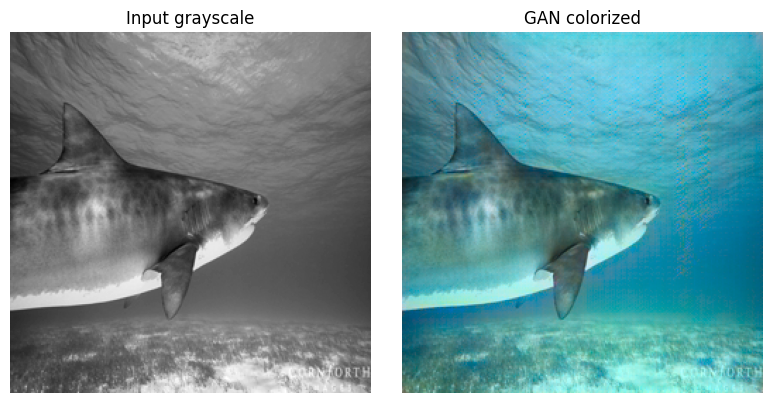

In [3]:
TEST_IMG    = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01491361/n01491361_10385.JPEG"
#"/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01537544/n01537544_1.JPEG"
#"/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01491361/n01491361_10385.JPEG"
#"/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01491361/n01491361_1019.JPEG"
#"/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01491361/n01491361_1000.JPEG"  # <- any RGB image

# ---------- Pre-process test image ------------------------------
rgb     = Image.open(TEST_IMG).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
rgb_np  = np.array(rgb) / 255.0                # [0,1]
lab_np  = color.rgb2lab(rgb_np).astype("float32")

L_in    = lab_np[..., 0:1] / 50.0 - 1.0        # [-1,1]
L_t     = torch.from_numpy(L_in).permute(2,0,1).unsqueeze(0).to(device)

# ---------- GAN inference (AMP optional) ------------------------
with torch.no_grad(), torch.cuda.amp.autocast():
    ab_pred = G(L_t).cpu().squeeze(0)          # 2×H×W, [-1,1]

ab_pred_np = ab_pred.permute(1,2,0).numpy() * 110.0
L_orig_np  = (L_in * 50.0 + 50.0)              # back to 0-100

lab_out = np.concatenate([L_orig_np, ab_pred_np], axis=2)
rgb_out = (color.lab2rgb(lab_out) * 255).astype("uint8")

# ---------- Visualize -------------------------------------------
plt.figure(figsize=(8,4))
# Grayscale (as 3-channel for viewing)
plt.subplot(1,2,1)
plt.imshow(rgb.convert("L"), cmap="gray")
plt.title("Input grayscale"); plt.axis("off")

# Colorized
plt.subplot(1,2,2)
plt.imshow(rgb_out)
plt.title("GAN colorized"); plt.axis("off")
plt.tight_layout(); plt.show()